# ACCESS features on simplification data sets

Computes ACCESS feature values for all src-tgt pairs in crowdsourced data sets.
- ASSET: uses a diverse range of rewriting operations (more natural, open simplifications)
- Turk: lexical simplification
- HSplit: syntactic simplification


In [1]:
import sys
sys.path.append("../") # go to parent dir

from muss_utils import get_features
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from easse.sari import corpus_sari
from easse.fkgl import corpus_fkgl
from easse.bertscore import corpus_bertscore

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [30]:
# dataset = 'asset_test' # 
dataset = 'asset_dev'
# dataset = 'turk_test'

if dataset.startswith('asset'):
    file = f'/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
    columns = ['src_text'] + [f'tgt_text_{i}' for i in range(10)]
elif dataset.startswith('turk'):
    file = f'/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
    columns = ['src_text'] + [f'tgt_text_{i}' for i in range(8)]
else:
    raise NotImplementedError

df = pd.read_csv(file, sep='\t', header=None, names=columns)
df['src_id'] = df.index
df.head(3)

,src_text,tgt_text_0,tgt_text_1,tgt_text_2,tgt_text_3,tgt_text_4,tgt_text_5,tgt_text_6,tgt_text_7,tgt_text_8,tgt_text_9,src_id
0,"Adjacent counties are Marin (to the south), Me...","countries next to it are Marin, Mendocino, Lak...","Nearby counties are Marin, Mendocino, Lake, Na...","Adjacent counties are Marin, Mendocino, Lake, ...","Neighboring counties are Marin, Mendocino, Lak...","Adjacent counties are Marin (south), Mendocino...","Counties next to it are Marin (to the south), ...","Marin, Mendocino, Lake, Napa, Solano, and Cont...","Adjacent counties are Marin, Mendocino, Lake, ...","Counties next door are Marin (south), Mendocin...","Nearby counties are Marin (to the south), Mend...",0
1,A Georgian inscription around the drum attests...,A writing around the drum confirms his name.,A Georgian writing on the drum is his name.,An inscription around the drum has his name.,His name is on the drum. It's a Georgian inscr...,A Georgian inscription around the drum confirm...,A Georgian writing around the drum says his name.,There is Georgian writing around the drum that...,An inscription around the drum is evidence of ...,Georgian writing around the drum verifies his ...,Its name is referred by a Georgian inscription...,1
2,They would later return to the revived series ...,They would return to the new series in the 200...,They returned to the series in the 2008 Christ...,They later returned to the revived series in t...,They brought back the series in a Christmas sp...,They would return to the series in the 2008 Ch...,They would later return to the revived series ...,They later showed up in the 2008 Christmas Spe...,They returned to the series in the 2008 Christ...,"The returned in the 2008 Christmas Special, ""T...","Later, they would return to the revived series...",2


In [31]:
dfm = df.melt(id_vars=['src_id', 'src_text'], var_name='tgt_text_id', value_name='tgt_text')
dfm.sort_values(by=['src_id', 'tgt_text_id'], axis=0, inplace=True)
dfm.head(14)

,src_id,src_text,tgt_text_id,tgt_text
0,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_0,"countries next to it are Marin, Mendocino, Lak..."
2000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_1,"Nearby counties are Marin, Mendocino, Lake, Na..."
4000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_2,"Adjacent counties are Marin, Mendocino, Lake, ..."
6000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_3,"Neighboring counties are Marin, Mendocino, Lak..."
8000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_4,"Adjacent counties are Marin (south), Mendocino..."
10000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_5,"Counties next to it are Marin (to the south), ..."
12000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_6,"Marin, Mendocino, Lake, Napa, Solano, and Cont..."
14000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_7,"Adjacent counties are Marin, Mendocino, Lake, ..."
16000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_8,"Counties next door are Marin (south), Mendocin..."
18000,0,"Adjacent counties are Marin (to the south), Me...",tgt_text_9,"Nearby counties are Marin (to the south), Mend..."


In [32]:
def compute_features(row):
    scores = get_features(row['src_text'], row['tgt_text'])
    return scores

dfm1 = dfm.progress_apply(compute_features, axis=1).apply(pd.Series)
dfm = pd.concat([dfm, dfm1], axis=1)
print(dfm.columns)

100%|██████████| 20000/20000 [03:39<00:00, 91.29it/s] 


Index(['src_id', 'src_text', 'tgt_text_id', 'tgt_text', 'len_ratio', 'lev_sim',
       'word_rank', 'tree_depth'],
      dtype='object')


In [33]:
# def compute_metrics(row):
#     scores = {}
#     fkgl = corpus_fkgl(row['tgt_text'])
#     print(fkgl)
#     scores['fkgl'] = fkgl
#     return scores

# dfm1 = dfm.progress_apply(compute_metrics, axis=1).apply(pd.Series)
# dfm = pd.concat([dfm, dfm1], axis=1)
# print(dfm.columns)

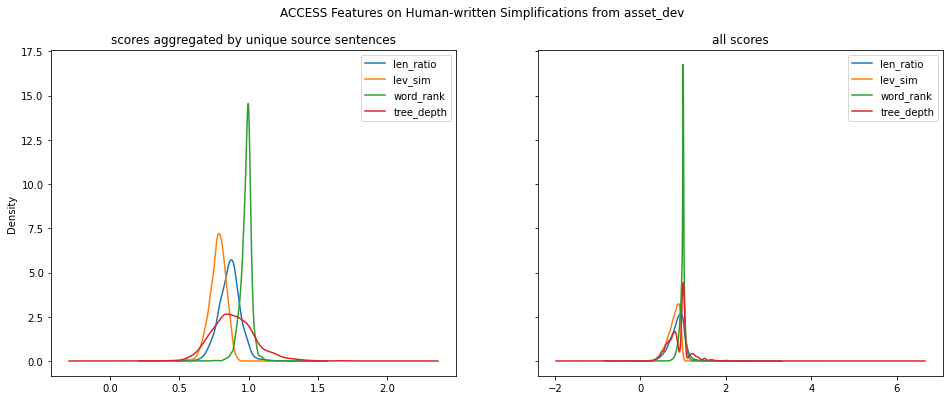

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

fig.suptitle(f'ACCESS Features on Human-written Simplifications from {dataset}')

dfm.groupby('src_id')['len_ratio'].mean().plot(kind='kde', ax=axes[0], legend=True)
dfm.groupby('src_id')['lev_sim'].mean().plot(kind='kde', ax=axes[0], legend=True)
dfm.groupby('src_id')['word_rank'].mean().plot(kind='kde', ax=axes[0], legend=True)
dfm.groupby('src_id')['tree_depth'].mean().plot(kind='kde', ax=axes[0], legend=True)

axes[0].set_title(f'scores aggregated by unique source sentences')

dfm['len_ratio'].plot(kind='kde', ax=axes[1], legend=True)
dfm['lev_sim'].plot(kind='kde', ax=axes[1], legend=True)
dfm['word_rank'].plot(kind='kde', ax=axes[1], legend=True)
dfm['tree_depth'].plot(kind='kde', ax=axes[1], legend=True)

axes[1].set_title(f'all scores')

plt.savefig(f'../results/plots/ACCESS_features_on_{dataset}.png', dpi=200)

<AxesSubplot:ylabel='Density'>

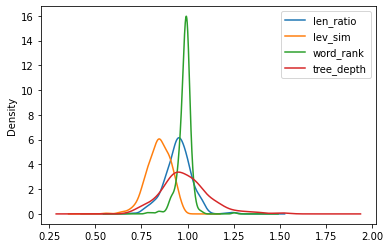

In [20]:

# plt.legend()

In [13]:
# dfm.groupby('src_id')['len_ratio']

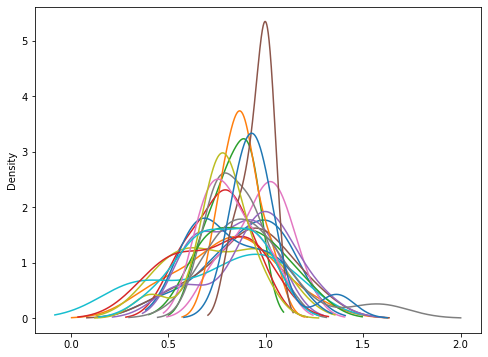

In [27]:
# classes = ["class 1"] * 5 + ["class 2"] * 5
# vals = [1,3,5,1,3] + [2,6,7,5,2]
# p_df = pd.DataFrame({"class": classes, "vals": vals})

fig, ax = plt.subplots(figsize=(8,6))
for i, (label, gdf) in enumerate(dfm.groupby('src_id')):
    if i > 20:
        break
#     print(len(gdf))
    gdf['len_ratio'].plot(kind="kde", ax=ax, label=label)
#     gdf['len_ratio'].plot(kind="box", ax=ax, label=label, positions=np.arange(0.0,4.0,1.0))
# plt.legend()


In [ ]:
# def load_dataset(file):
#     src_texts = []
#     tgt_texts = []
#     with open(file, 'r', encoding='utf8') as f:
#         for line in f:
#             sents = line.strip().split('\t')
#             src_texts.append(sents[0])
#             tgt_texts.append(sents[1:])
#     return src_texts, tgt_texts

# dataset = '/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/en/aligned/asset_de.tsv'
# src_texts, tgt_texts = load_dataset(dataset)

In [52]:
# all_feats = []
# for src, tgts in zip(src_texts, tgt_texts):
#     feats = []
#     for tgt in tgts:
#         feats.append(get_features(src, tgt))
#     all_feats.append(feats)
# all_feats[:1]

[[{'len_ratio': 0.7582938388625592,
   'lev_sim': 0.7439353099730458,
   'word_rank': 1.071347346372436,
   'tree_depth': 0.625},
  {'len_ratio': 1.085308056872038,
   'lev_sim': 0.9545454545454546,
   'word_rank': 1.0,
   'tree_depth': 1.0},
  {'len_ratio': 0.4549763033175355,
   'lev_sim': 0.6254071661237784,
   'word_rank': 0.9850776779941764,
   'tree_depth': 0.5},
  {'len_ratio': 0.8246445497630331,
   'lev_sim': 0.8779220779220779,
   'word_rank': 1.0394386135868747,
   'tree_depth': 1.25},
  {'len_ratio': 1.014218009478673,
   'lev_sim': 0.851764705882353,
   'word_rank': 1.0137337119881595,
   'tree_depth': 1.0},
  {'len_ratio': 1.0900473933649288,
   'lev_sim': 0.8344671201814059,
   'word_rank': 1.015656164796063,
   'tree_depth': 0.875},
  {'len_ratio': 0.6824644549763034,
   'lev_sim': 0.7492957746478873,
   'word_rank': 1.0873017127652163,
   'tree_depth': 1.0},
  {'len_ratio': 1.080568720379147,
   'lev_sim': 0.9202733485193622,
   'word_rank': 1.0246764235062307,
   'tre

In [48]:
def avg_scores(l):
    d = {}
    keys = list(l[0].keys())
    for k in keys:
#         print(k)
        vals = np.array([l_i[k] for l_i in l])
        d[f'{k}_mean'] = vals.mean()
        d[f'{k}_std'] = vals.std()
    return d

In [49]:
avg_feats = []
for i, (s, tgts, feats) in enumerate(zip(src_texts, tgt_texts, all_feats)):
#     if i > 1:
#         break
#     print(f'{i}\t{s}\t{tgts}\t{feats}\n')
    avg_feats.append(avg_scores(feats))
avg_feats[:3]

[{'len_ratio_mean': 0.885308056872038,
  'len_ratio_std': 0.19687137618628905,
  'lev_sim_mean': 0.7974392051963176,
  'lev_sim_std': 0.10912229396569519,
  'word_rank_mean': 1.0211963222173577,
  'word_rank_std': 0.03372803914262686,
  'tree_depth_mean': 0.8625,
  'tree_depth_std': 0.2197299478905868},
 {'len_ratio_mean': 0.8041666666666666,
  'len_ratio_std': 0.23033791601808756,
  'lev_sim_mean': 0.7552030452084897,
  'lev_sim_std': 0.12637070121489186,
  'word_rank_mean': 0.965236751466392,
  'word_rank_std': 0.04969667479014128,
  'tree_depth_mean': 0.8142857142857143,
  'tree_depth_std': 0.16963345838625593},
 {'len_ratio_mean': 0.8272727272727274,
  'len_ratio_std': 0.09799118698777318,
  'lev_sim_mean': 0.8149940477232945,
  'lev_sim_std': 0.11153247469302438,
  'word_rank_mean': 1.0311641711089075,
  'word_rank_std': 0.022346867502421333,
  'tree_depth_mean': 0.8833333333333334,
  'tree_depth_std': 0.10671873729054747}]

In [136]:
df = pd.DataFrame(avg_feats)
df

,len_ratio_mean,len_ratio_std,lev_sim_mean,lev_sim_std,word_rank_mean,word_rank_std,tree_depth_mean,tree_depth_std
0,0.885308,0.196871,0.797439,0.109122,1.021196,0.033728,0.862500,0.219730
1,0.804167,0.230338,0.755203,0.126371,0.965237,0.049697,0.814286,0.169633
2,0.827273,0.097991,0.814994,0.111532,1.031164,0.022347,0.883333,0.106719
3,0.761386,0.139069,0.756050,0.147578,1.121528,0.124963,0.866667,0.163299
4,0.819136,0.162922,0.783937,0.104878,0.949423,0.026913,0.833333,0.129099
...,...,...,...,...,...,...,...,...
354,0.604327,0.230027,0.627071,0.157844,0.972244,0.047175,0.787500,0.201944
355,0.812941,0.230627,0.730933,0.097577,1.004782,0.028005,0.975000,0.207666
356,0.838012,0.143913,0.772663,0.142331,0.995983,0.009907,0.725000,0.242384
357,0.906395,0.120461,0.830371,0.104908,0.983196,0.046835,0.828571,0.166599


<AxesSubplot:>

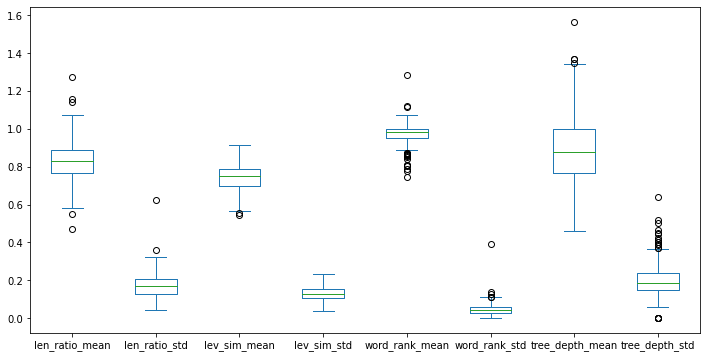

In [139]:
df.plot(kind='box', figsize=(12,6))

In [63]:
def avg_std_deviation_from_equal_sample_size(s):
    """
    https://www.statology.org/averaging-standard-deviations/
    
    Average S.D. = √ (s1**2 +  s2**2 + … + sk**2) / k
    """
#     print(sum(i**2 for i in s))
    return math.sqrt(sum(i**2 for i in s) / len(s))

print(df['len_ratio_mean'].mean())
print(avg_std_deviation_from_equal_sample_size(df['len_ratio_std']))

print(df['lev_sim_mean'].mean())
print(avg_std_deviation_from_equal_sample_size(df['lev_sim_std']))

print(df['word_rank_mean'].mean())
print(avg_std_deviation_from_equal_sample_size(df['word_rank_std']))

print(df['tree_depth_mean'].mean())
print(avg_std_deviation_from_equal_sample_size(df['tree_depth_std']))

0.8293269304846277
0.1828132246065166
0.7457806817217253
0.135319171753172
0.9740878884136109
0.05596096288931894
0.8837587458966288
0.2151091834782573
